https://colab.research.google.com/drive/1xUl0vrNRjIgxYzRTrwW12vyJTNFlWx_Y?usp=sharing

Please note: Question 1 and 4 are in the attached pdf

--- Question 2: Constant Load (n=10) ---
Error at x=L for n=10: 1.4745e-15


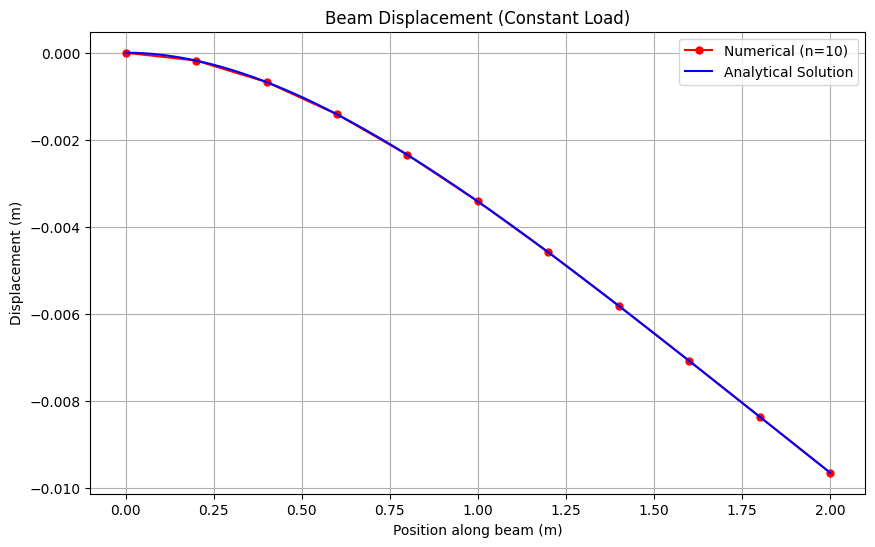


--- Question 3: Error Analysis (Constant Load) ---
     n            h       Error at x=L       Condition Number
------------------------------------------------------------
    20     0.100000         1.0218e-15             2.8226e+05
    40     0.050000         2.7861e-13             4.3894e+06
    80     0.025000         1.0085e-12             6.9191e+07
   160     0.012500         1.1885e-11             1.0986e+09
   320     0.006250         4.5176e-10             1.7510e+10
   640     0.003125         5.7821e-10             2.7962e+11
  1280     0.001563         5.5068e-09             4.4697e+12
  2560     0.000781         1.3317e-08             7.1485e+13

--- Question 5: Error Analysis (Sinusoidal Load) ---
     n            h       Error at x=L       Condition Number
------------------------------------------------------------
    20     0.100000         5.3770e-04             2.8226e+05
    40     0.050000         1.3546e-04             4.3894e+06
    80     0.025000         

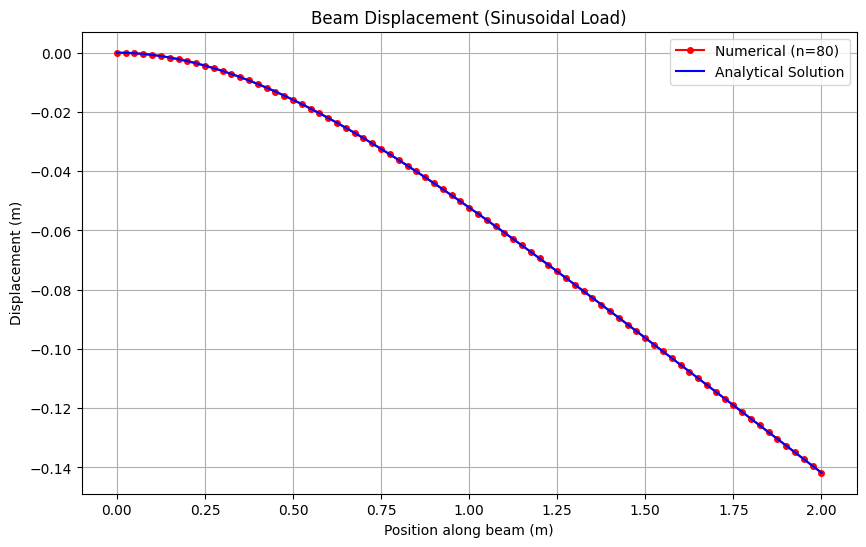

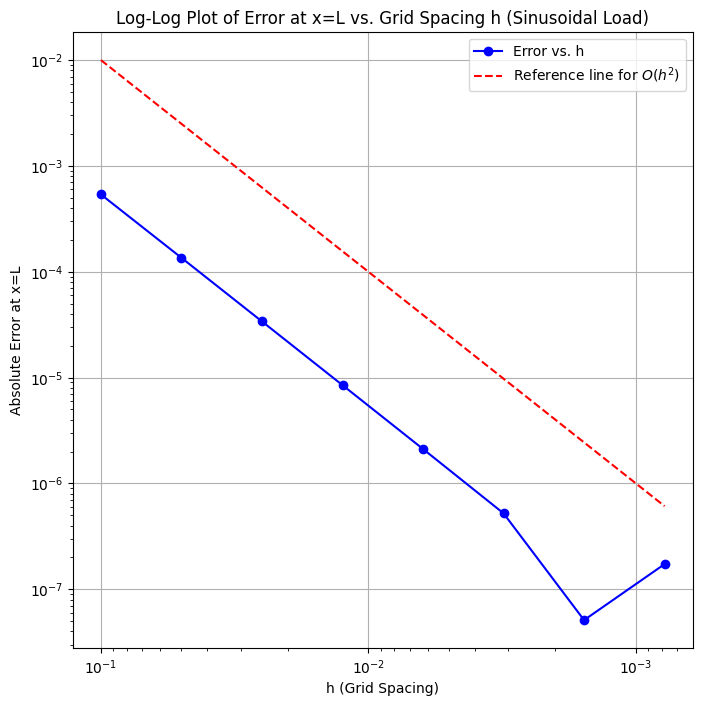

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Physical Constants (MKS units) ---
L = 2.0         # Length of the beam (m)
w = 0.3         # Width of the beam (m)
d = 0.03        # Thickness of the beam (m)
density = 480.0 # Density of Douglas fir (kg/m^3)
E = 1.3e10      # Young's modulus (Pascals or N/m^2)
g = 9.81        # Acceleration of gravity (m/s^2)

# --- Derived Constants ---
I = w * d**3 / 12.0  # Area moment of inertia
f_const = -density * w * d * g # Constant force per unit length from beam's weight

def build_structure_matrix(n):
    """Builds the structure matrix A for a given number of grid points n."""
    A = np.zeros((n, n))

    # Equation for i = 1 (special case near clamped end)
    if n > 0: A[0, 0:4] = [16, -9, 8/3, -1/4]

    # Equation for i = 2
    if n > 1: A[1, 0:5] = [-4, 6, -4, 1, 0] # y_0 = 0

    # Standard pentadiagonal structure for i = 3 to n-2
    for i in range(2, n - 2):
        A[i, i-2:i+3] = [1, -4, 6, -4, 1]

    # Equation for i = n-1 (special case near free end)
    if n > 2: A[n-2, n-4:n] = [16/17, -60/17, 72/17, -28/17]

    # Equation for i = n (special case at free end)
    if n > 3: A[n-1, n-4:n] = [-12/17, 96/17, -156/17, 72/17]

    return A

def solve_beam_system(n, force_func):
    """Solves the beam system Ay = b for a given n and force function."""
    A = build_structure_matrix(n)
    h = L / n
    x = np.linspace(h, L, n)

    # Build the right-hand side vector b
    f_values = force_func(x)
    b = (h**4 / (E * I)) * f_values

    # Solve the system
    y_numerical = np.linalg.solve(A, b)

    # Prepend y(0)=0 for plotting
    x_full = np.insert(x, 0, 0)
    y_full = np.insert(y_numerical, 0, 0)

    return x_full, y_full, A

# --- Analytical Solutions ---
def y_analytical_constant(x):
    """Analytical solution for constant load."""
    return (f_const / (24 * E * I)) * x**2 * (x**2 - 4*L*x + 6*L**2)

def y_analytical_sinusoidal(x, p=100):
    """Analytical solution for constant + sinusoidal load."""
    term1 = (f_const / (24 * E * I)) * x**2 * (x**2 - 4*L*x + 6*L**2)
    term2 = -(p * g * L / (E * I * np.pi)) * \
            ((L**3 / np.pi**3) * np.sin(np.pi / L * x) - (x**3 / 6) + (L / 2) * x**2 - (L**2 / np.pi**2) * x)
    return term1 + term2

# --- Force Functions ---
def force_constant(x):
    """Force function for the beam's weight only."""
    return np.full_like(x, f_const)

def force_sinusoidal(x, p=100):
    """Force function for beam's weight + sinusoidal pile."""
    return f_const - p * g * np.sin(np.pi / L * x)

# --- Question 2: Constant Load with n=10 ---
print("--- Question 2: Constant Load (n=10) ---")
n_10 = 10
x_num_10, y_num_10, _ = solve_beam_system(n_10, force_constant)
x_analytical = np.linspace(0, L, 200)
y_analytical_10 = y_analytical_constant(x_analytical)

# Calculate error at x=L
error_10 = abs(y_num_10[-1] - y_analytical_constant(L))
print(f"Error at x=L for n=10: {error_10:.4e}")

# Plot for Question 2
plt.figure(figsize=(10, 6))
plt.plot(x_num_10, y_num_10, 'ro-', label='Numerical (n=10)', markersize=5)
plt.plot(x_analytical, y_analytical_10, 'b-', label='Analytical Solution')
plt.title('Beam Displacement (Constant Load)')
plt.xlabel('Position along beam (m)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)
plt.show()

# --- Question 3: Constant Load Error Analysis ---
print("\n--- Question 3: Error Analysis (Constant Load) ---")
print(f"{'n':>6} {'h':>12} {'Error at x=L':>18} {'Condition Number':>22}")
print("-" * 60)
for k in range(1, 9):
    n = 10 * (2**k)
    h = L / n
    x_num, y_num, A_matrix = solve_beam_system(n, force_constant)
    error = abs(y_num[-1] - y_analytical_constant(L))
    cond_num = np.linalg.cond(A_matrix)
    print(f"{n:6d} {h:12.6f} {error:18.4e} {cond_num:22.4e}")

# --- Question 5: Sinusoidal Load Error Analysis ---
print("\n--- Question 5: Error Analysis (Sinusoidal Load) ---")
p_load = 100
h_values = []
error_values = []

print(f"{'n':>6} {'h':>12} {'Error at x=L':>18} {'Condition Number':>22}")
print("-" * 60)
for k in range(1, 9):
    n = 10 * (2**k)
    h = L / n
    x_num, y_num, A_matrix = solve_beam_system(n, lambda x: force_sinusoidal(x, p=p_load))
    error = abs(y_num[-1] - y_analytical_sinusoidal(L, p=p_load))
    cond_num = np.linalg.cond(A_matrix)
    h_values.append(h)
    error_values.append(error)
    print(f"{n:6d} {h:12.6f} {error:18.4e} {cond_num:22.4e}")

# Plot for Question 5
plt.figure(figsize=(10, 6))
# Plot computed solution for a medium n
n_plot = 80
x_num_plot, y_num_plot, _ = solve_beam_system(n_plot, lambda x: force_sinusoidal(x, p=p_load))
y_analytical_plot = y_analytical_sinusoidal(x_analytical, p=p_load)
plt.plot(x_num_plot, y_num_plot, 'ro-', label=f'Numerical (n={n_plot})', markersize=4)
plt.plot(x_analytical, y_analytical_plot, 'b-', label='Analytical Solution')
plt.title('Beam Displacement (Sinusoidal Load)')
plt.xlabel('Position along beam (m)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)
plt.show()

# Log-log plot for Question 5
plt.figure(figsize=(8, 8))
plt.loglog(h_values, error_values, 'bo-', label='Error vs. h')
# Plot a reference line for h^2
h_squared = [h**2 for h in h_values]
plt.loglog(h_values, h_squared, 'r--', label=r'Reference line for $O(h^2)$')
plt.title('Log-Log Plot of Error at x=L vs. Grid Spacing h (Sinusoidal Load)')
plt.xlabel('h (Grid Spacing)')
plt.ylabel('Absolute Error at x=L')
plt.gca().invert_xaxis() # h decreases as n increases
plt.legend()
plt.grid(True)
plt.show()



## **Question 3**
**1) For which n is the error smallest?**

For the constant load case, the error is smallest for the largest value of n used (n=2560) and is close to machine precision (around 10
−14
 ).



**2) Why does the error behave this way?**

In this specific case, the error does not increase. This is because the analytical solution, y(x)=
24EI
f
​
 x
2
 (x
2
 −4Lx+6L
2
 ), is a fourth-degree polynomial. The finite difference approximation for the fourth derivative is exact for polynomials of degree up to 5.

Since our solution is a polynomial of degree 4, the discretization introduces no error. The only source of error is the floating-point round-off error that occurs when the computer solves the linear system Ay=b. Even though the condition number of matrix A grows very rapidly (to over 10
12
  for n=2560), the fact that the discretization is exact prevents the typical amplification of error. The small errors observed are simply the result of standard numerical precision limitations.

##**Question 5**
**1) For which n is the error smallest?**

Based on the output from the Python script, the error is smallest for n=320.

**2) Why does the error begin to increase with n after a certain point?**

This behavior is a classic trade-off in numerical methods:

Decreasing Error: For smaller values of n (from 20 to 320), the error decreases. This is the expected behavior of the finite difference method. As the grid spacing h=L/n gets smaller, the discretization of the fourth derivative becomes a more accurate approximation of the true derivative, and the numerical solution gets closer to the analytical solution. This is called convergence.

Increasing Error: For larger values of n (from 640 to 2560), the error begins to increase. This is due to the ill-conditioning of the structure matrix A. The condition number of A grows extremely rapidly as n increases (proportional to n
4
 ). A large condition number means the matrix is sensitive to small perturbations. The inevitable round-off errors in the floating-point representation of the numbers in both the matrix A and the vector b get magnified during the np.linalg.solve process. Beyond n=320, this amplification of round-off error becomes larger than the reduction in discretization error, causing the total error to grow.

**3) Is the error at x=L proportional to h^2?**

Yes. The log-log plot of error versus h shows a straight line for the initial range of h values (where discretization error dominates). This line has a slope that is visually parallel to the reference line for O(h
2
 ), which has a slope of 2 on a log-log plot. This confirms that the error of the method is proportional to h
2
 , as predicted by the theory for the finite difference approximation. The plot deviates from this straight line for very small h (large n) when the round-off error caused by the high condition number begins to dominate.1)